## <b>Solving 2d Laplace equation via Phycisc Informed Neural Networks (PINNs)<b>

This notebook gives an example of how a Phycisc Informed Neural Network (PINN) can be easily and quickly used with the TensorFlow (TF) .fit method. 

This approach is used to solve the 2d Laplace equation on a square domain [-1,1]$\times$[-1,1].

For a detailed description of the method, as well as to have further details, please refer to the <a href=https://github.com/maziarraissi/PINNs>following repo</a>, and to:
<ul>
  <li>Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. <a href=https://www.sciencedirect.com/science/article/pii/S0021999118307125>Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations</a> Journal of Computational Physics 378 (2019): 686-707.</li>
  <li>Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. <a href=https://arxiv.org/abs/1711.10561>Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations</a> arXiv preprint arXiv:1711.10561 (2017).</li>
  <li>Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. <a href=https://arxiv.org/abs/1711.10566>Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations</a> arXiv preprint arXiv:1711.10566 (2017).</li>
</ul> 

Import the required libraries. The <a href=https://py-pde.readthedocs.io/en/latest/index.html>*py-pde*</a> package is used here to compute the reference solution.

In [14]:
import numpy as np
from sklearn import preprocessing 
import tensorflow as tf
from matplotlib import pyplot as plt
plt.close('all')

import seaborn as sns
sns.set_style("darkgrid")

from datetime import datetime
from pde import CartesianGrid, solve_laplace_equation

Define the computational geometry (square domain $\Omega$ = [-1,1]$\times$[-1,1]) and the *collocation poits*, that are the points inside $\Omega$ where the physical contraint is enforced. 

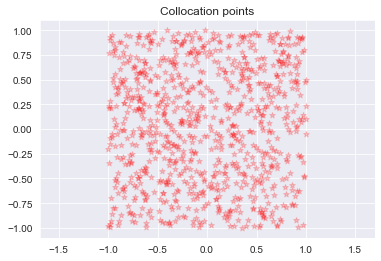

In [15]:
lb = np.array([-1,1])
ub = np.array([-1,1])

box = np.array([[-1, -1], 
                [1, -1],
                [1, 1],
                [-1, 1]])

# define collocation points
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
N_rand = 30**2
coll_pts = np.column_stack((scaler.fit_transform(np.random.rand(N_rand).reshape(-1,1)),
                          scaler.fit_transform(np.random.rand(N_rand).reshape(-1,1))))

plt.figure()
plt.scatter(coll_pts[:,0],coll_pts[:,1], c='r', marker='*', alpha=0.2)
plt.axis('equal')
plt.title('Collocation points')
plt.show()

Compute the reference solunion via *py-pde* package.

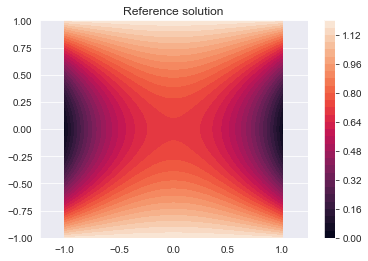

In [16]:
# define a Cartesian Grid for the solution
grid = CartesianGrid([[-1.1, 1.1]] * 2, 50)
bcs = [{"value": "sin(y)"}, {"value": "sin(x)"}]
bcs = [{"value": "x**2"}, {"value": "x**2"}]

# solve and plot the solution
res = solve_laplace_equation(grid, bcs)

x_BCs = np.linspace(-1,1,50).T
y_BCd = np.linspace(-1,1,50).T
x, y = np.meshgrid(x_BCs, y_BCd)

plt.figure()
plt.contourf(x,y,res.data,30)
plt.axis('equal')
plt.colorbar()
plt.title('Reference solution')
plt.show()

Define the input/output for training the the Deep Neural Network (DNN), i.e., `X_train` are the $(x,y)$ coordinates of the boundary points and `y_train` are the values of the function at these points. Moreover, we define also `X_r`, the vector of the $(x,y)$ coordinates of the collocation points.

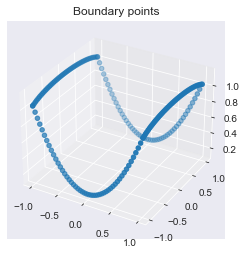

In [17]:
BCs_pts = np.row_stack((np.column_stack((x_BCs,-np.ones_like(x_BCs))),
                       np.column_stack((np.ones_like(x_BCs),x_BCs)),
                       np.column_stack((np.flipud(x_BCs),np.ones_like(x_BCs))),
                       np.column_stack((-np.ones_like(x_BCs),np.flipud(x_BCs)))))


BCs_vals = res.interpolate(BCs_pts)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(BCs_pts[:,0],BCs_pts[:,1],BCs_vals,marker = 'o')
plt.title('Boundary points')


# Define inputs/outputs for training
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE) # Set data type for TF

X_r    = tf.constant(coll_pts, dtype=DTYPE)   # -> collocation points
X_train = tf.constant(BCs_pts, dtype=DTYPE)   # -> boundary points
y_train = tf.constant(BCs_vals.reshape(-1,1), dtype=DTYPE)  #-> values of function at boundary points

n_input = 2
n_output = 1

Define the `PINN_NeuralNet` class at first

In [18]:
class PINN_NeuralNet(tf.keras.Model):

    def __init__(self,
                 output_dim=1,
                 num_hidden_layers=8,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)
        # define all layers in init
        # Layer of Block 1
        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim
        
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=activation,
                                             kernel_initializer=kernel_initializer)
                       for _ in range(self.num_hidden_layers)]

        self.out = tf.keras.layers.Dense(output_dim)

        self.hist = []
        self.iter = 0

    def call(self, X, training=False):
        Z = X
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)

Then define the `PINN_solver` class to specify the solver settings.

In [19]:
# Define the solver architecture
class PINN_solver():
    def __init__(self, model, coll_pts = np.zeros((2,2))):
        self.model = model
        
        # (x,y) of the collocation points (where PDE is enforced)
        coll_pts = tf.constant(coll_pts)
        self.x = coll_pts[:,0]
        self.y = coll_pts[:,1]
        
        # for history and display callbacks
        self.hist = []
        self.iter = 0
        
    
    def display_callback(self, xr=None):
        ''' print loss on command window '''
        if self.iter % 50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(self.iter,self.train_loss))
            # print(self.train_loss)
    
    
    def history_callback(self, xr=None):
        ''' stores loss history '''
        self.hist.append(self.train_loss)
        self.iter+=1
        
        
    def fun_r(self, u_xx, u_yy):
        """Residual of the PDE"""
        return u_xx + u_yy
        
    
    def get_r(self):
        with tf.GradientTape() as g:
            x,y = self.x, self.y
            g.watch(x)
            with tf.GradientTape(persistent=False) as gg:
                gg.watch(x)
                u = self.model(tf.stack([x, y], axis=1))
            u_x = gg.gradient(u, x)  
        u_xx = g.gradient(u_x, x) 
        del g, gg
        
        with tf.GradientTape() as g:
            x,y = self.x, self.y
            g.watch(y)
            with tf.GradientTape(persistent=False) as gg:
                gg.watch(y)
                u = self.model(tf.stack([x, y], axis=1))
            u_y = gg.gradient(u, y)  
        u_yy = g.gradient(u_y, y) 
        del g, gg
        
        return self.fun_r(u_xx, u_yy)     
    
    
    def loss_fun(self, x_ds, y_ds): #model, X_r, X_data, u_data):
        # Compute phi^r
        r = self.get_r()
        loss_PDE = tf.reduce_mean(tf.square(r))
        loss_DNN = tf.reduce_mean(tf.square(y_ds - self.model(x_ds)))
        loss = loss_DNN + loss_PDE
                
        return loss
        
    
    def get_grad(self, x_ds, y_ds): #(model, X_r, X_data, u_data):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with respect to trainable variables
            tape.watch(self.model.trainable_variables)
            # predictions = self.model(x_ds, training=False)
            # loss = tf.keras.losses.mean_squared_error(y_ds, predictions)
            loss = self.loss_fun(x_ds, y_ds)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        del tape
        return loss, gradients
    
    
    def loss_funciton(self,y_true, y_pred):
        ''' define loss functio (which can be standard or custom) '''
        loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
        return loss
    
    
    
    ''' .fit method '''    
    def fit(self,
            X_train,
            y_train,
            optimizer=tf.keras.optimizers.Adam(),
            epochs=50,
            batch_size=32,
            verbose=True):
        ''' implement standard fit method via sub-classing'''

        @tf.function
        def train_step(x_ds,y_ds):
            loss, gradients = self.get_grad(x_ds,y_ds)
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            
            train_loss = tf.reduce_mean(loss)
            train_loss_mse = tf.reduce_mean(tf.keras.metrics.mean_squared_error(y_ds, self.model(x_ds)))
            return train_loss, train_loss_mse
    
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(X_train.shape[0]).batch(batch_size)
        for epoch in range(epochs):
            for x_ds, y_ds in train_ds:
                loss, loss_mse = train_step(x_ds, y_ds)
                        
            self.train_loss = loss.numpy()
            if verbose:
                self.display_callback()
            self.history_callback()

Train the model on the dataset `X_train`, `y_train`

In [20]:
sub_classing_model = PINN_NeuralNet(output_dim=n_output,
                                    num_hidden_layers=8,
                                    num_neurons_per_layer=20,
                                    activation='swish',
                                    kernel_initializer='he_normal')

solver = PINN_solver(sub_classing_model, coll_pts)

batch_size = round(.2*X_train.shape[0])
epochs = 500
t_start = datetime.now()
solver.fit(X_train,
           y_train,
           optimizer=tf.keras.optimizers.Adam(),
           epochs=epochs,
           batch_size=batch_size)
t_end = datetime.now()
print(t_end - t_start)

It 00000: loss = 7.11680217e-01
It 00050: loss = 1.07962042e-03
It 00100: loss = 4.80867383e-04
It 00150: loss = 3.10141161e-04
It 00200: loss = 2.00632089e-04
It 00250: loss = 1.39258947e-04
It 00300: loss = 8.58948604e-05
It 00350: loss = 5.56912471e-05
It 00400: loss = 3.02931460e-05
It 00450: loss = 3.65045554e-05
0:01:12.965353


Plot training history

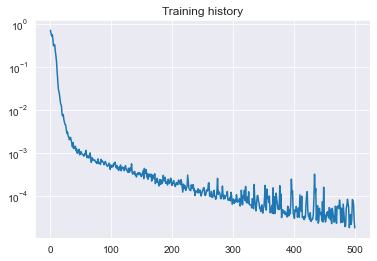

In [21]:
# plot history
plt.figure()
plt.plot(solver.hist)
plt.title('Training history')
# plt.plot(running_mean(data, N))
plt.yscale('log')

Test the model on a new set of test points

79/79 [==============================] - 0s 1ms/step
mse = 0.12419438739153299


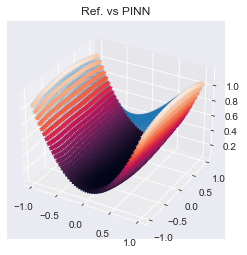

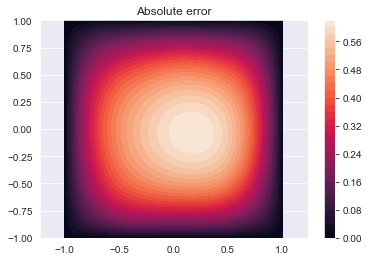

In [13]:
# new grid for testing
x_grid = np.linspace(-1,1,50).T
y_grid = np.linspace(-1,1,50).T
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
X_test = np.column_stack((X_grid.reshape(-1,1),Y_grid.reshape(-1,1)))

sol_PINN = sub_classing_model.predict(X_test)
sol_ref = res.interpolate(X_test)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(sol_PINN, sol_ref.reshape(-1, 1))
print('mse =', mse)

# Ref. vs PINN
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_test[:,0],X_test[:,1],sol_PINN,c = sol_PINN,marker = '*', alpha = 1)
ax.scatter(X_test[:, 0], X_test[:, 1], sol_ref, marker='o', alpha=.1)
plt.title('Ref. vs PINN')
plt.show()

plt.figure()
plt.contourf(X_grid, Y_grid, np.reshape(
    abs(sol_PINN - sol_ref.reshape(-1, 1)), X_grid.shape), 30)
plt.axis('equal')
plt.colorbar()
plt.title('Absolute error')
plt.show()
